# 1. Importación de Librerías

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

# 2. Preprocesamiento de Datos

In [12]:
train = pd.read_csv('Training.csv')
test = pd.read_csv('Testing.csv')

data = pd.concat([train, test], axis=0)

In [13]:
for column in data:
    na_percent = data[column].isna().sum() / len(data)
    if (na_percent > 0.0):
        print(f'{column}: {na_percent:.2%}')

Unnamed: 133: 100.00%


In [14]:
data = data.dropna(axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4962 entries, 0 to 41
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.1+ MB


In [15]:
# Features
X = data.drop('prognosis', axis=1)
# Labels
true_labels = data['prognosis']

In [16]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_labels)

# 3. Análisis de Exploratorio de Datos

In [17]:
X.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
count,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,...,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000
mean,0.138049,0.160016,0.021967,0.045143,0.021967,0.162233,0.139057,0.045143,0.045143,0.021967,...,0.021967,0.021967,0.021967,0.023378,0.023176,0.023176,0.023176,0.023176,0.023378,0.023176
std,0.344986,0.366658,0.146590,0.207639,0.146590,0.368702,0.346041,0.207639,0.207639,0.146590,...,0.146590,0.146590,0.146590,0.151115,0.150478,0.150478,0.150478,0.150478,0.151115,0.150478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


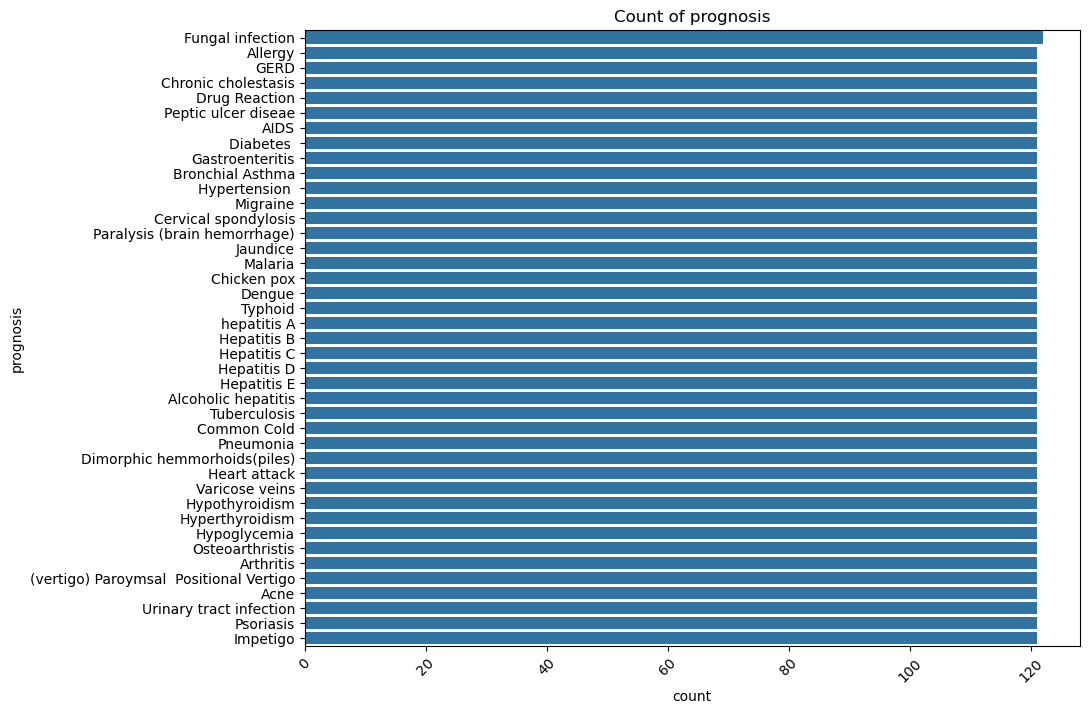

In [18]:
for column in data.select_dtypes(include='object'):
    plt.figure(figsize=(10, 8))
    sns.countplot(data[column])
    plt.title(f'Count of {column}')
    plt.xticks(rotation=45)
    plt.show()


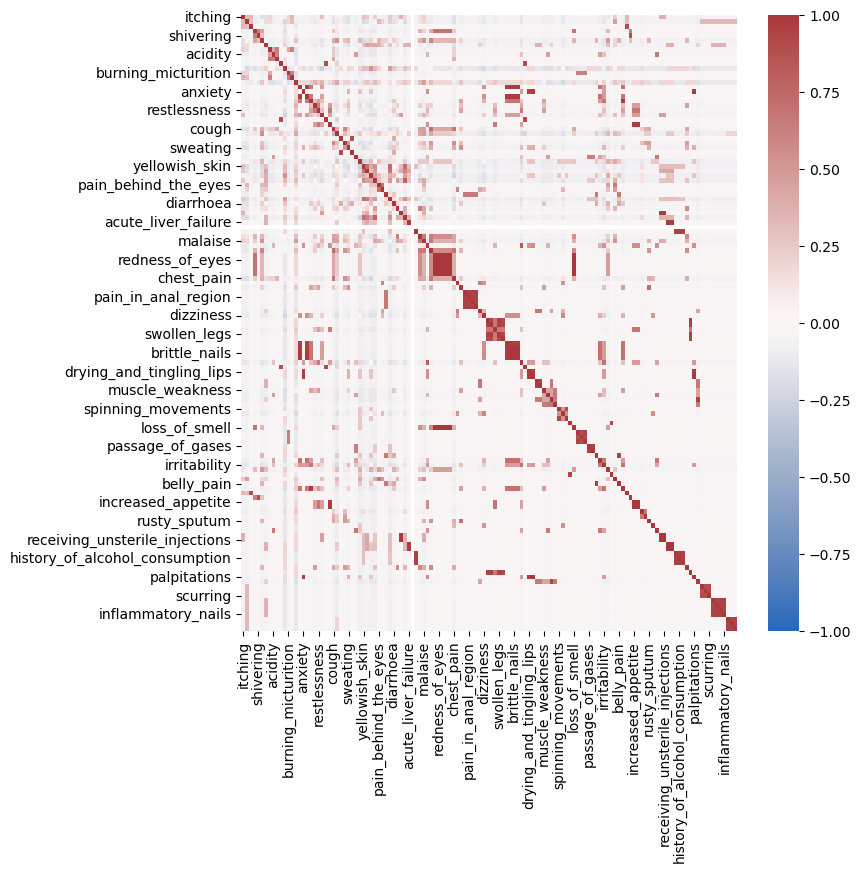

In [19]:
figure3 = plt.figure(figsize=(8,8))
sns.heatmap(X.corr(),
            cmap='vlag',
            vmin=-1,
            vmax=1)
plt.show()

#  4. Método de K means Clustering

In [20]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

best_ari = -1
best_silhouette = -1
best_n_components = -1
best_clusters = float('inf')
best_n_clusters = -1

for n_components in range(2, 40):
    for n_clusters in range(2, 40):
        preprocessor = Pipeline(
            [
                ("pca", PCA(n_components=n_components, random_state=42))
            ]
        )

        clusterer = Pipeline(
            [
                (
                    "kmeans", KMeans(
                        n_clusters=n_clusters,
                        random_state=42
                    )
                )
            ]
        )

        pipe = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("clusterer", clusterer)
            ]
        )

        pipe.fit(X)
        preprocessed_data = pipe["preprocessor"].transform(X)
        predicted_labels = pipe["clusterer"]["kmeans"].labels_

        unique_clusters = len(set(predicted_labels))

        if unique_clusters == 1:
            continue

        silhouette = silhouette_score(preprocessed_data, predicted_labels)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        if ari > best_ari and silhouette > 0.65 and unique_clusters <= 42:
            best_ari = ari
            best_silhouette = silhouette
            best_n_components = n_components
            best_clusters = unique_clusters
            best_n_clusters = n_clusters
            print('Best Model:')
            print('n_components:', n_components)
            print('n_clusters:', n_clusters)
            print('ARI:', ari)
            print('Silhouette Score:', silhouette)

print("Best Model:")
print("ARI:", best_ari)
print("Silhouette Score:", best_silhouette)
print("Number of Components:", best_n_components)
print("Number of Clusters:", best_n_clusters)
print("Number of Unique Clusters:", best_clusters)

Best Model:
n_components: 2
n_clusters: 23
ARI: 0.3246929313091449
Silhouette Score: 0.6513736962461856
Best Model:
n_components: 2
n_clusters: 30
ARI: 0.45367552332954064
Silhouette Score: 0.6540023404182517
Best Model:
n_components: 2
n_clusters: 32
ARI: 0.5022029239496816
Silhouette Score: 0.6510090172340329
Best Model:
n_components: 2
n_clusters: 35
ARI: 0.5095513401804308
Silhouette Score: 0.6703321793895163
Best Model:
n_components: 2
n_clusters: 36
ARI: 0.53714283027434
Silhouette Score: 0.6819779202878069
Best Model:
n_components: 2
n_clusters: 39
ARI: 0.5468105502005013
Silhouette Score: 0.6822182668858701
Best Model:
n_components: 3
n_clusters: 35
ARI: 0.55374270693294
Silhouette Score: 0.6633889761272679
Best Model:
n_components: 3
n_clusters: 36
ARI: 0.5798701943706077
Silhouette Score: 0.6505925658205278
Best Model:
n_components: 4
n_clusters: 29
ARI: 0.6212034525718386
Silhouette Score: 0.6719908100209826
Best Model:
n_components: 4
n_clusters: 30
ARI: 0.6239149770534578


In [21]:
best_ari, best_silhouette, best_n_components, best_n_clusters

(0.9519193444905224, 0.8045194012516956, 35, 39)

In [22]:
preprocessor = Pipeline([
    ("pca", PCA(n_components=26, random_state=42))
])

kmeans = KMeans(
    n_clusters=best_n_clusters,
    init="k-means++",
    n_init=50,
    max_iter=500,
    random_state=42
)


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", kmeans)
])


pipeline.fit(X)


predicted_labels = pipeline.predict(X)


In [23]:

new_predicted_labels = pipeline["kmeans"].fit_predict(preprocessed_data)

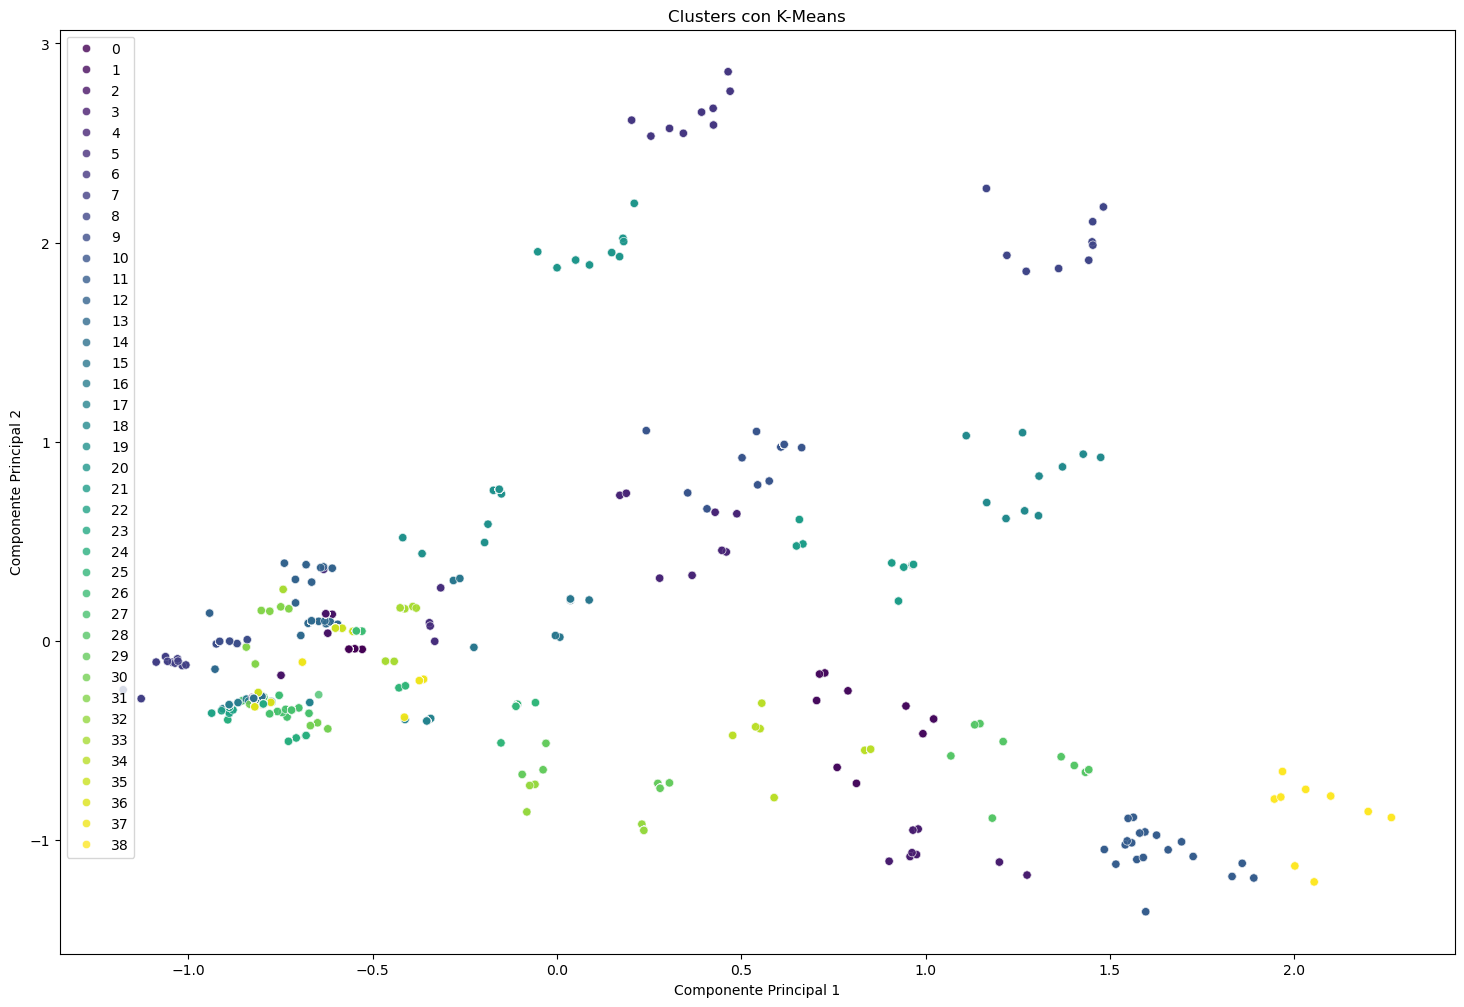

In [24]:
plt.figure(figsize=(18, 12))
sns.scatterplot(
    x=preprocessed_data[:, 0],
    y=preprocessed_data[:, 1],
    hue=new_predicted_labels,
    palette='viridis',
    legend="full",
    alpha=0.8
)
plt.title('Clusters con K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [25]:
preprocessed_data = pipeline["preprocessor"].transform(X)[:, :2]


new_kmeans = KMeans(
    n_clusters=best_n_clusters,
    init="k-means++",
    n_init=50,
    max_iter=500,
    random_state=42
)


new_predicted_labels = new_kmeans.fit_predict(preprocessed_data)


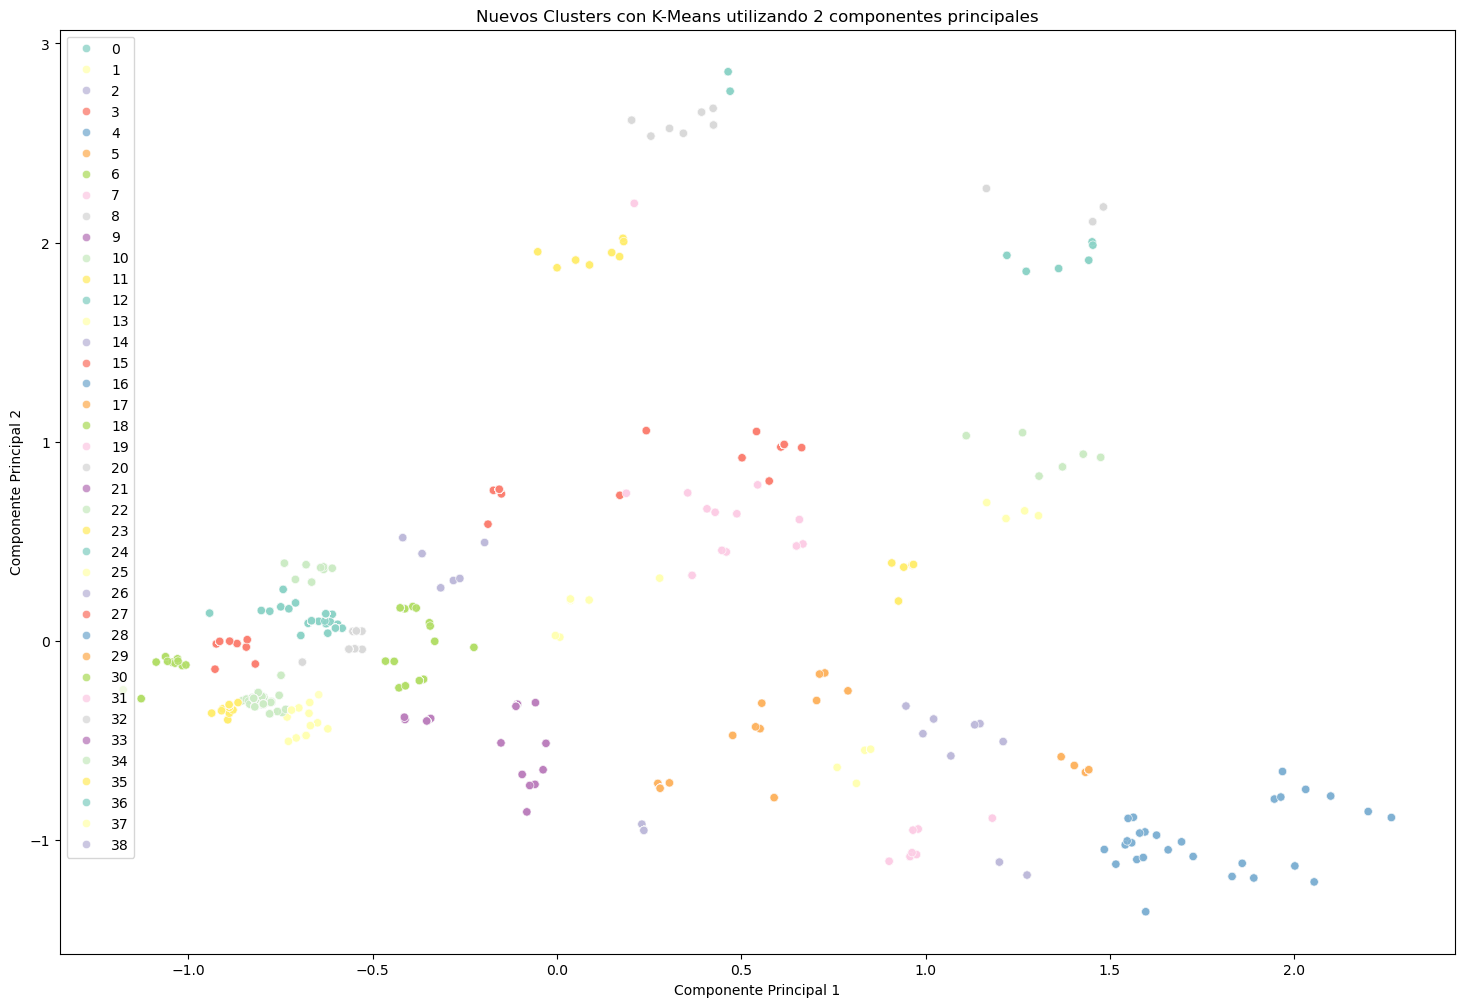

In [26]:
plt.figure(figsize=(18, 12))
sns.scatterplot(
    x=preprocessed_data[:, 0],
    y=preprocessed_data[:, 1],
    hue=new_predicted_labels,
    palette="Set3",
    legend="full",
    alpha=0.8
)
plt.title('Nuevos Clusters con K-Means utilizando 2 componentes principales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# 5. Método de DBSCAN

In [27]:
best_ari = -1
best_silhouette = -1
best_n_components = -1
best_eps = -1
best_min_samples = -1
best_clusters = float('inf')

for n_components in range(2, 40):
    for eps in [0.1, 0.5, 1.0, 1.5, 2.0]:
        for min_samples in [5, 10, 15, 20]:
            preprocessor = Pipeline(
                [
                    ("pca", PCA(n_components=n_components, random_state=42))
                ]
            )

            clusterer = Pipeline(
                [
                    (
                        "dbscan", DBSCAN(
                            eps=eps,
                            min_samples=min_samples
                        )
                    )
                ]
            )

            pipe = Pipeline(
                [
                    ("preprocessor", preprocessor),
                    ("clusterer", clusterer)
                ]
            )

            pipe.fit(X)
            preprocessed_data = pipe["preprocessor"].transform(X)
            predicted_labels = pipe["clusterer"]["dbscan"].labels_

            unique_clusters = len(set(predicted_labels)) - (1 if -1 in predicted_labels else 0)

            if unique_clusters == 1:
                continue

            silhouette = silhouette_score(preprocessed_data, predicted_labels)
            ari = adjusted_rand_score(true_labels, predicted_labels)

            if ari > best_ari and silhouette > 0.65 and unique_clusters <= 42:
                best_ari = ari
                best_silhouette = silhouette
                best_n_components = n_components
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = unique_clusters
                print('Best Model:')
                print('n_components:', n_components)
                print('n_clusters:', n_clusters)
                print('ARI:', ari)
                print('Silhouette Score:', silhouette)

print("Best Model:")
print("ARI:", best_ari)
print("Silhouette Score:", best_silhouette)
print("Number of Components:", best_n_components)
print("Epsilon:", best_eps)
print("Min Samples:", best_min_samples)
print("Number of Clusters:", best_clusters)


Best Model:
n_components: 12
n_clusters: 39
ARI: 0.6526403266010615
Silhouette Score: 0.6525633125772382
Best Model:
n_components: 15
n_clusters: 39
ARI: 0.6572585759245572
Silhouette Score: 0.6788706207747086
Best Model:
n_components: 26
n_clusters: 39
ARI: 0.6829198178731037
Silhouette Score: 0.68880791413285
Best Model:
n_components: 27
n_clusters: 39
ARI: 0.7648490742214734
Silhouette Score: 0.711127192140365
Best Model:
n_components: 29
n_clusters: 39
ARI: 0.8132210229956007
Silhouette Score: 0.7339216234889705
Best Model:
n_components: 30
n_clusters: 39
ARI: 0.8488382984037004
Silhouette Score: 0.7520887895241305
Best Model:
n_components: 31
n_clusters: 39
ARI: 0.9293108625239798
Silhouette Score: 0.7896714233116409
Best Model:
n_components: 32
n_clusters: 39
ARI: 0.951729790389713
Silhouette Score: 0.8080042974075493
Best Model:
n_components: 33
n_clusters: 39
ARI: 0.9751982902764141
Silhouette Score: 0.8233201685103684
Best Model:
n_components: 34
n_clusters: 39
ARI: 0.99979175

In [28]:
best_ari, best_n_components, best_eps, best_min_samples, best_clusters

(0.9997917520202194, 34, 1.0, 5, 41)

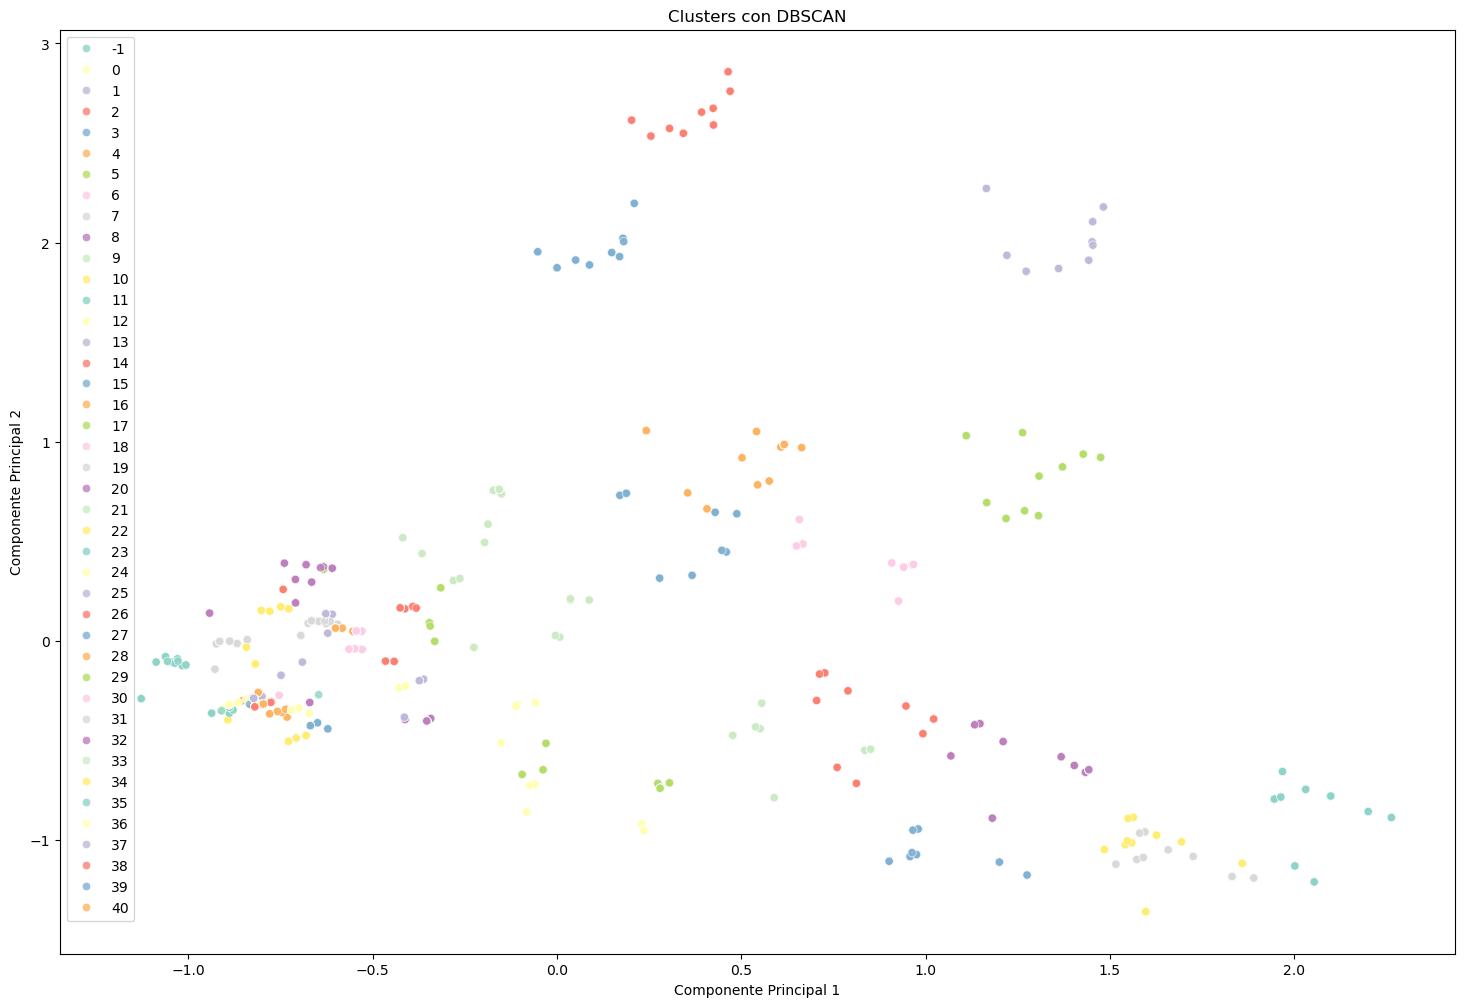

In [29]:
best_eps = best_eps
best_min_samples = best_min_samples

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)

predicted_labels_dbscan = dbscan.fit_predict(preprocessed_data)

plt.figure(figsize=(18, 12))
sns.scatterplot(
    x=preprocessed_data[:, 0],
    y=preprocessed_data[:, 1],
    hue=predicted_labels_dbscan,
    palette='Set3',
    legend='full',
    alpha=0.8
)
plt.title('Clusters con DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


# Resultados

In [30]:
# Create pipeline for DBSCAN

dbscan_pipe = Pipeline(steps=[
    ('preprocessor', PCA(n_components=34, random_state=42)),
    ('dbscan', DBSCAN(eps=1, min_samples=5))
])

dbscan_pipe.fit(X)
preprocessed_data = dbscan_pipe["preprocessor"].transform(X)
dbscan_labels = dbscan_pipe["dbscan"].labels_

# Calculate ARI and silhouette score for DBSCAN
dbscan_silhouette = silhouette_score(preprocessed_data, dbscan_labels)
dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)

# Create pipeline for KMeans
kmeans_pipe = Pipeline(steps=[
    ('preprocessor', PCA(n_components=35, random_state=42)),
    ('kmeans', KMeans(n_clusters=39, random_state=42))
])

kmeans_pipe.fit(X)
preprocessed_data = kmeans_pipe["preprocessor"].transform(X)
kmeans_labels = kmeans_pipe["kmeans"].labels_

# Calculate ARI and silhouette score for KMeans
kmeans_silhouette = silhouette_score(preprocessed_data, kmeans_labels)
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

# Print the scores
print(f"DBSCAN ARI: {dbscan_ari}, DBSCAN Silhouette: {dbscan_silhouette}")
print(f"KMeans ARI: {kmeans_ari}, KMeans Silhouette: {kmeans_silhouette}")


DBSCAN ARI: 0.9997917520202194, DBSCAN Silhouette: 0.8281497781045049
KMeans ARI: 0.9519193444905224, KMeans Silhouette: 0.8045194012516956
